**Mounting Google Drive in Google Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing Fastai and Dependencies**

In [ ]:
!pip install fastai==2.0.19
!pip install torch
!pip install torchvision

**Image Classification with Fastai and Sklearn: Analysis and Evaluation**

In [ ]:
from fastai import *
from fastai.vision.all import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import csv
!pip install Pathlib
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
from sklearn.preprocessing import label_binarize

**Listing Files in Directory Using Python Pathlib**

In [ ]:
x  = r'/content/drive/MyDrive/EYE'
path = Path(x)
path.ls()

(#3) [Path('/content/drive/MyDrive/EYE/OPEN'),Path('/content/drive/MyDrive/EYE/CLOSED'),Path('/content/drive/MyDrive/EYE/Test')]

**Image Data Loading and Augmentation with PyTorch and Fastai**

In [ ]:
np.random.seed(40)
data = ImageDataLoaders.from_folder(path, train = '.', valid_pct=0.2, item_tfms=Resize(460),
                                  batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)], size=224,
                                  num_workers=4)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


**Visualizing Data Batch**

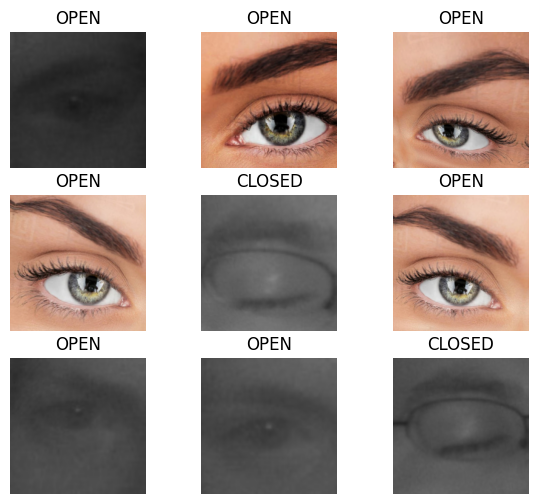

In [ ]:
data.show_batch(nrows=3, figsize=(7,6))

In [ ]:
data
print(data.vocab)
len(data.vocab)
data.c

['CLOSED', 'OPEN', 'Test']


3

**Creating a Convolutional Neural Network (CNN) Learner with ResNet-18 Architecture**

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy], model_dir = Path('../kaggle/working'),path = Path("."))

**Finding Optimal Learning Rate and Plotting Suggestions using Fastai's**

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


TypeError: 'bool' object is not iterable

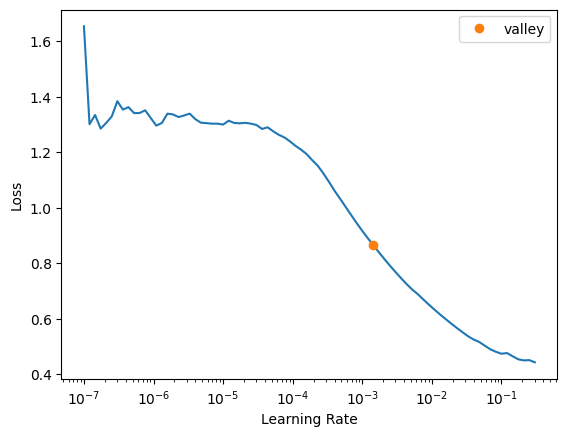

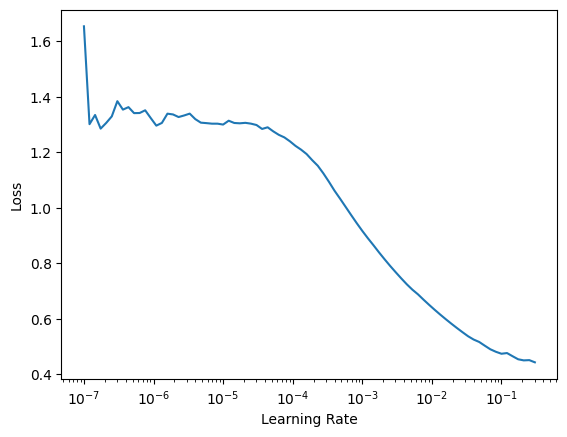

In [ ]:
learn.lr_find()
learn.recorder.plot_lr_find(suggestions=True)(str(False))

**Training a Model with One Cycle Learning Rate Scheduling**

In [ ]:
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(40,slice(lr1,lr2))

epoch,train_loss,valid_loss,accuracy,time
0,0.844620,0.631083,0.875000,00:35
1,0.419360,0.853678,0.875000,00:22
2,0.328473,0.100720,0.968750,00:23
3,0.254713,0.000011,1.000000,00:22
4,0.202472,0.000000,1.000000,00:22
5,0.165269,0.000000,1.000000,00:22
6,0.138917,0.000000,1.000000,00:22
7,0.174790,0.000000,1.000000,00:23
8,0.152086,0.000000,1.000000,00:28
9,0.133973,0.000000,1.000000,00:22


epoch,train_loss,valid_loss,accuracy,time
0,0.844620,0.631083,0.875000,00:35
1,0.419360,0.853678,0.875000,00:22
2,0.328473,0.100720,0.968750,00:23
3,0.254713,0.000011,1.000000,00:22
4,0.202472,0.000000,1.000000,00:22
5,0.165269,0.000000,1.000000,00:22
6,0.138917,0.000000,1.000000,00:22
7,0.174790,0.000000,1.000000,00:23
8,0.152086,0.000000,1.000000,00:28
9,0.133973,0.000000,1.000000,00:22


**Fine-tuning a Pretrained Model with Unfreezing Layers**

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.000097,0.000000,1.000000,00:30
1,0.000048,0.000000,1.000000,00:29
2,0.000031,0.000000,1.000000,00:30
3,0.000023,0.000000,1.000000,00:29
4,0.000018,0.000000,1.000000,00:33
5,0.000015,0.000000,1.000000,00:29
6,0.000012,0.000000,1.000000,00:30
7,0.000011,0.000000,1.000000,00:29
8,0.000009,0.000000,1.000000,00:29
9,0.000008,0.000000,1.000000,00:30


**Plotting Training Loss**

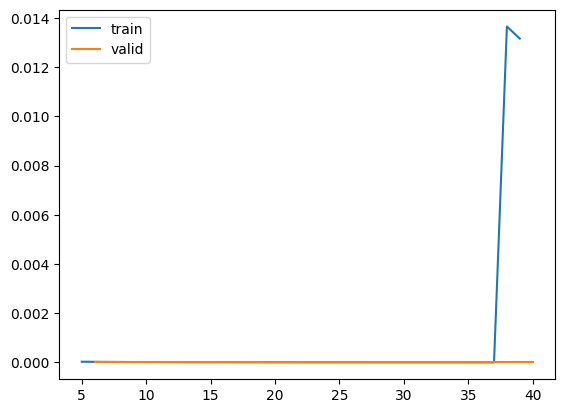

In [ ]:
learn.recorder.plot_loss()

**Visualizing Confusion Matrix for Model Interpretation**

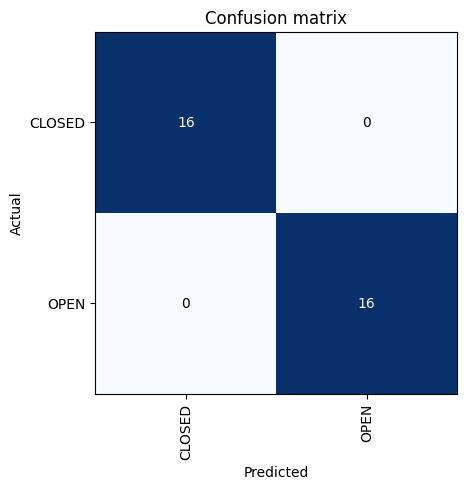

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**Visualizing Top Losses**

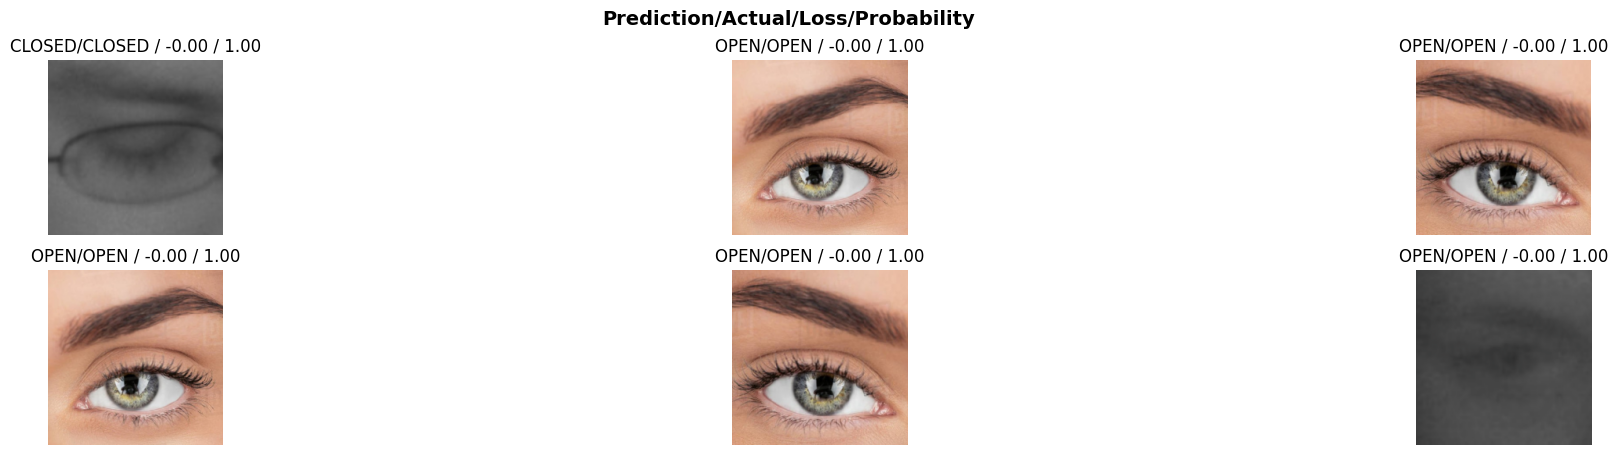

In [ ]:
interp.plot_top_losses(6,figsize = (25,5))

In [ ]:
img = PILImage.create('/content/drive/MyDrive/EYE/Test/closed_eye_test2.jpg')
print(learn.predict(img)[0])

CLOSED


In [ ]:
y_prob, y_true = learn.get_preds(dl=learn.dls.valid)
y_pred = y_prob[:, 1] > 0.5

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


**Classification Report**

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.31      0.31        13
           1       0.55      0.58      0.56        19
           2       0.00      0.00      0.00         1

    accuracy                           0.45        33
   macro avg       0.29      0.30      0.29        33
weighted avg       0.44      0.45      0.45        33



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Extracting Positive Class Probabilities and Binarizing True Labels**

In [ ]:
y_prob_positive = y_prob[:, 1]
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

**Calculating and Plotting ROC Curve for Multi-Class Classification**

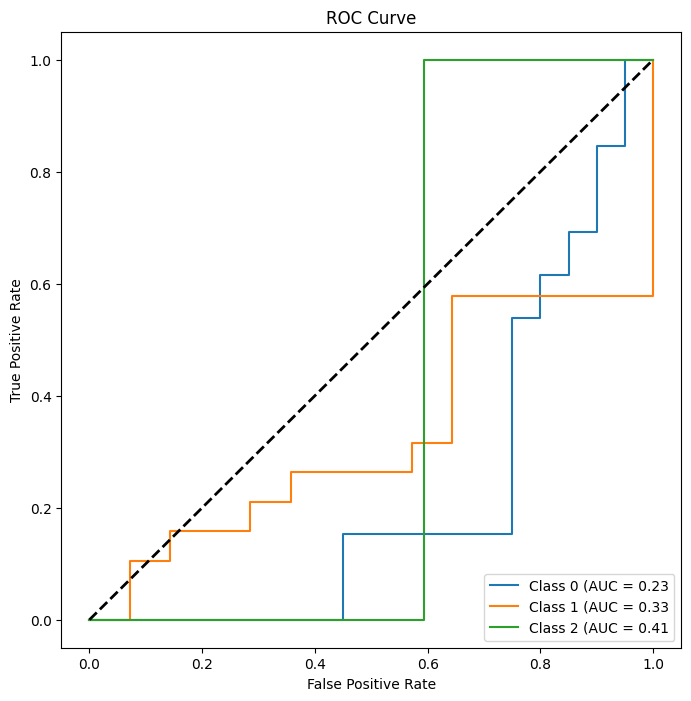

In [ ]:
#Calculating ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_prob.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(y_prob.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Precision-Recall Curve Analysis for Multi-Class Classification**

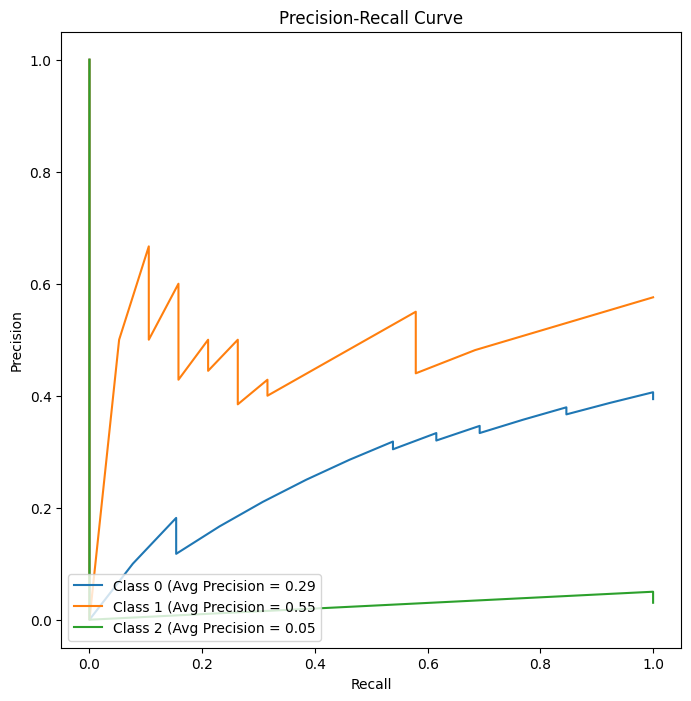

In [ ]:
# Calculate precision-recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(y_prob.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve((y_true == i).float(), y_prob[:, i])
    average_precision[i] = average_precision_score((y_true == i).float(), y_prob[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(8, 8))
for i in range(y_prob.shape[1]):
    plt.plot(recall[i], precision[i], label=f'Class {i} (Avg Precision = {average_precision[i]:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()